In [1]:
import pandas as pd
import numpy as np
import altair as alt
from vega_datasets import data

In [2]:
df = data.cars().drop('Name', axis=1)
df['Year'] = df['Year'].dt.year  # simplify
df.head()

,Acceleration,Cylinders,Displacement,Horsepower,Miles_per_Gallon,Origin,Weight_in_lbs,Year
0,12.0,8,307.0,130.0,18.0,USA,3504,1970
1,11.5,8,350.0,165.0,15.0,USA,3693,1970
2,11.0,8,318.0,150.0,18.0,USA,3436,1970
3,12.0,8,304.0,150.0,16.0,USA,3433,1970
4,10.5,8,302.0,140.0,17.0,USA,3449,1970


In [3]:
df2 = df.copy()
labs = {}
for col, dfcol in df.items():
    if dfcol.dtype == np.object:
        dfcol = dfcol.astype('category')
    if isinstance(dfcol.dtype, pd.core.dtypes.dtypes.CategoricalDtype):
        y = dfcol.cat.codes
        xlabs = dfcol.cat.categories.values
        xnorm = np.linspace(0,1,len(dfcol.cat.categories))
    else:
        y = dfcol
        nticks = 11
        if dfcol.dtype == np.int64:
            ndec = 0
            nticks = min(nticks, len(dfcol.unique()))
        else:
            ndec = 1
        if nticks < 11:
            xorig = list(sorted(dfcol.unique()))
            xnorm = [(x - y.min())/(y.max() - y.min()) for x in xorig] 
        else:
            xnorm = np.linspace(0,1,nticks)
            xorig = [(x*(y.max() - y.min())+y.min()) for x in xnorm] 
        xlabs = [f'{x:.{ndec}f}' for x in xorig]
    labs[col] = pd.Series(xlabs, index=xnorm)
    df2[col] = (y - y.min())/(y.max() - y.min())

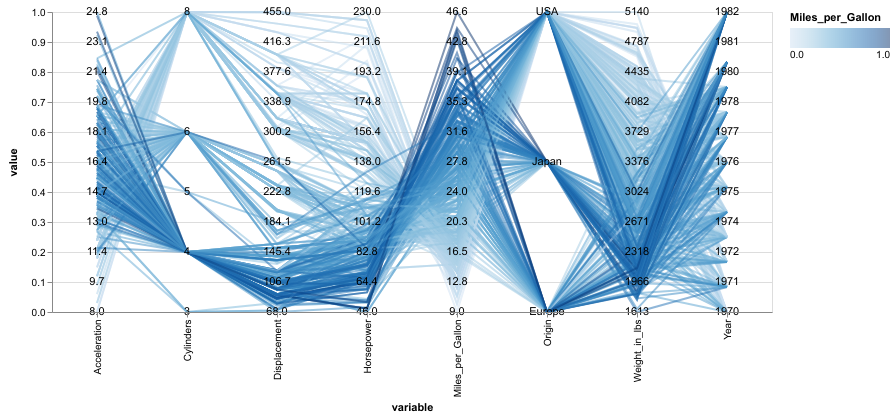

In [4]:
vcolor = 'Miles_per_Gallon'
color_spec = '' if df[vcolor].dtype in [np.float64,np.int64] else ':N'
df2melt = df2.reset_index().melt(['index',vcolor])
dfvcolor = df2melt[df2melt.variable==df2.columns[0]].copy()
dfvcolor['value'] = dfvcolor[vcolor]
dfvcolor['variable'] = vcolor
df2melt = pd.concat([df2melt,dfvcolor], ignore_index=True)

pcplot = alt.Chart(df2melt).mark_line().encode(
    x='variable:N',
    y='value:Q',
    detail='index',
    color=vcolor+color_spec,
    opacity=alt.value(0.5)
)
for v in list(sorted(df2melt['variable'].unique())):
    dflab = labs[v].reset_index()
    if dflab.shape[0]>11:
        continue
    dflab.columns = ['value','lab']
    dflab['variable'] = v
    pcplot += alt.Chart(dflab).mark_text(
        align='center',
        baseline='middle',
    ).encode(
        x='variable',
        y='value',
        text='lab'
    )
pcplot